# Task 9 – Forecasting Pipeline

This notebook rebuilds Task 9 end-to-end: a rolling 7×24 hour demand forecast that compares
statistical, machine-learning, and baseline models while exporting report-ready artefacts.

In [1]:
# Check package versions and basic setup
import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels
import plotly
import matplotlib

print("═" * 60)
print("PACKAGE VERSIONS")
print("═" * 60)
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"xgboost: {xgb.__version__}")
print(f"statsmodels: {statsmodels.__version__}")
print(f"plotly: {plotly.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print()

def show_columns(df, name="Dataset"):
    """Display column types and missing value percentages."""
    print(f"\n{'─' * 60}")
    print(f"{name.upper()} COLUMN SUMMARY")
    print(f"{'─' * 60}")
    print(f"{'Column':<30} {'Type':<15} {'% NA':>10}")
    print(f"{'─' * 60}")
    for col in df.columns:
        pct_na = 100 * df[col].isna().sum() / len(df)
        print(f"{col:<30} {str(df[col].dtype):<15} {pct_na:>9.2f}%")
    print(f"{'─' * 60}\n")

════════════════════════════════════════════════════════════
PACKAGE VERSIONS
════════════════════════════════════════════════════════════
pandas: 1.5.3
numpy: 1.26.4
xgboost: 3.0.5
statsmodels: 0.14.5
plotly: 6.3.0
matplotlib: 3.10.7



In [2]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

ROOT = Path.cwd().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.modeling_ml import (
    set_seed,
    build_ml_dataset,
    train_xgboost,
    predict_xgboost,
)
from src.forecasting import FEATURE_COLUMNS

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

TARGET = "Demand"
HORIZON = 24

REPORTS_DIR = ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"
CHECKS_DIR = REPORTS_DIR / "checks"

for path in (FIGURES_DIR, TABLES_DIR, CHECKS_DIR):
    path.mkdir(parents=True, exist_ok=True)


# =============================================================================
# ACADEMIC STYLE CONFIGURATION
# =============================================================================
def set_academic_style():
    """Configure matplotlib for publication-quality figures."""
    mpl.rcParams.update({
        "figure.figsize": (10, 4),
        "figure.facecolor": "white",
        "figure.dpi": 100,
        "axes.facecolor": "white",
        "savefig.facecolor": "white",
        "savefig.dpi": 300,
        "axes.grid": True,
        "grid.color": "#E5E5E5",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
        "grid.alpha": 0.7,
        "font.size": 11,
        "font.family": "sans-serif",
        "axes.titlesize": 12,
        "axes.titleweight": "bold",
        "axes.labelsize": 11,
        "axes.labelweight": "medium",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.fontsize": 10,
        "legend.framealpha": 0.9,
        "legend.edgecolor": "0.8",
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "lines.linewidth": 1.8,
        "lines.markersize": 6,
    })


def save_figure(fig: plt.Figure, shortname: str, dpi: int = 300) -> None:
    """Save figure to PNG and display inline."""
    fig.tight_layout()
    png_path = FIGURES_DIR / f"09_{shortname}.png"
    fig.savefig(png_path, dpi=dpi, bbox_inches="tight", facecolor="white", edgecolor="none")
    plt.show()
    print(f"  → Saved: {png_path.name}")


def display_table(df: pd.DataFrame, shortname: str) -> None:
    csv_path = TABLES_DIR / f"09_{shortname}.csv"
    df.to_csv(csv_path, index=False)
    display(df)


set_academic_style()

# =============================================================================
# COLOR PALETTE (Consistent across all figures)
# =============================================================================
COLORS = {
    "Actual": "#1f77b4",     # Blue
    "XGBoost": "#ff7f0e",    # Orange
    "SARIMA": "#2ca02c",     # Green
    "Naive": "#7f7f7f",      # Gray
    "SeasonalNaive": "#9467bd",  # Purple
}

# For seaborn compatibility
PALETTE = COLORS.copy()
sns.set_theme(style="whitegrid")

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Load training data and forecast data
# The pipeline uses historical data for model training and forecast.csv for evaluation
# ─────────────────────────────────────────────────────────────────────────────
TRAIN_PATH = ROOT / "data" / "processed" / "task5_features.parquet"
FORECAST_PATH = ROOT / "data" / "raw" / "forecast.csv"

if not TRAIN_PATH.exists():
    raise FileNotFoundError(f"Training data not found: {TRAIN_PATH}")
if not FORECAST_PATH.exists():
    raise FileNotFoundError(f"Forecast input not found: {FORECAST_PATH}")

# Load the full training dataset (2013-07-01 to 2014-06-30)
train_full_df = pd.read_parquet(TRAIN_PATH)
if "timestamp" not in train_full_df.columns:
    train_full_df = train_full_df.reset_index().rename(columns={"index": "timestamp"})
train_full_df["timestamp"] = pd.to_datetime(train_full_df["timestamp"], errors="coerce", utc=True)
train_full_df = train_full_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
if train_full_df["timestamp"].dt.tz is not None:
    train_full_df["timestamp"] = train_full_df["timestamp"].dt.tz_convert(None)

# Load the forecast period data (2014-07-01 to 2014-07-07)
forecast_df = pd.read_csv(FORECAST_PATH)
forecast_df["timestamp"] = pd.to_datetime(forecast_df["timestamp"], errors="coerce", utc=True)
forecast_df = forecast_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
forecast_df["timestamp"] = forecast_df["timestamp"].dt.tz_convert(None)

assert train_full_df["timestamp"].is_monotonic_increasing, "Training timestamps must be increasing"
assert forecast_df["timestamp"].is_monotonic_increasing, "Forecast timestamps must be increasing"

# Handle missing values
for df in [train_full_df, forecast_df]:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate(limit_direction="both")
    df[numeric_cols] = df[numeric_cols].fillna(method="ffill").fillna(method="bfill")

print("═" * 60)
print("DATA SUMMARY")
print("═" * 60)
print(f"Training data:  {train_full_df.shape[0]:,} rows")
print(f"  Time span:    {train_full_df['timestamp'].min()} → {train_full_df['timestamp'].max()}")
print(f"Forecast data:  {forecast_df.shape[0]:,} rows")
print(f"  Time span:    {forecast_df['timestamp'].min()} → {forecast_df['timestamp'].max()}")
print("═" * 60)

show_columns(forecast_df, "Forecast Dataset")
display(forecast_df.head())

════════════════════════════════════════════════════════════
DATA SUMMARY
════════════════════════════════════════════════════════════
Training data:  8,759 rows
  Time span:    2013-07-01 00:00:00 → 2014-06-30 23:00:00
Forecast data:  168 rows
  Time span:    2014-07-01 00:00:00 → 2014-07-07 23:00:00
════════════════════════════════════════════════════════════

────────────────────────────────────────────────────────────
FORECAST DATASET COLUMN SUMMARY
────────────────────────────────────────────────────────────
Column                         Type                  % NA
────────────────────────────────────────────────────────────
timestamp                      datetime64[ns]       0.00%
Demand                         float64              0.00%
pv                             float64              0.00%
Price                          float64              0.00%
Temperature                    float64              0.00%
Pressure (hPa)                 float64              0.00%
Cloud_cover (%

,timestamp,Demand,pv,Price,Temperature,Pressure (hPa),Cloud_cover (%),Cloud_cover_low (%),Cloud_cover_mid (%),Cloud_cover_high (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²)
0,2014-07-01 00:00:00,0.25,0.0,0.08233,13.0,1008.9,100,90,0,98,7.3,0,0,0,0.0
1,2014-07-01 01:00:00,0.26,0.0,0.07962,12.7,1009.1,100,96,67,100,6.4,0,0,0,0.0
2,2014-07-01 02:00:00,0.24,0.0,0.07408,12.5,1009.1,100,90,100,99,6.4,0,0,0,0.0
3,2014-07-01 03:00:00,0.25,0.0,0.07196,12.4,1009.1,100,95,100,98,6.7,0,0,0,0.0
4,2014-07-01 04:00:00,0.27,0.0,0.07028,12.2,1009.5,100,93,97,94,6.1,4,0,4,0.0


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Configure feature columns (common between train and forecast)
# ─────────────────────────────────────────────────────────────────────────────
# Find common numeric columns between train and forecast datasets
train_numeric = set(train_full_df.select_dtypes(include=[np.number]).columns)
forecast_numeric = set(forecast_df.select_dtypes(include=[np.number]).columns)
common_features = list(train_numeric.intersection(forecast_numeric))
common_features = [col for col in common_features if col.lower() != TARGET.lower()]

FEATURE_COLUMNS.clear()
FEATURE_COLUMNS.extend(common_features)

print(f"✓ Configured {len(FEATURE_COLUMNS)} common feature columns:")
print(FEATURE_COLUMNS)

✓ Configured 9 common feature columns:
['Temperature', 'Cloud_cover (%)', 'direct_normal_irradiance (W/m²)', 'Price', 'Shortwave_radiation (W/m²)', 'Wind_speed_10m (km/h)', 'Pressure (hPa)', 'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)']


In [5]:
# AUDIT: Define both stat_spec and xgb_params for rolling_forecast_7days
stat_spec = {
    "order": (2, 1, 2),
    "seasonal_order": (1, 1, 1, 24),
}

xgb_params = {
    "n_estimators": 600,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "gamma": 0.0,
    "random_state": RANDOM_SEED,
    "tree_method": "hist",
    "eval_metric": "rmse",  # Set on model, not in fit
}

print(f"✓ Statistical model spec: {stat_spec}")
print(f"✓ XGBoost params configured with {xgb_params['n_estimators']} estimators")

✓ Statistical model spec: {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 24)}
✓ XGBoost params configured with 600 estimators


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# Rolling 7-Day Out-of-Sample Forecast
# Strategy: Direct forecasting with 24h horizon, 0h lead time
# Models retrained each day using all available historical data
# ─────────────────────────────────────────────────────────────────────────────
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Combine training and forecast data for the rolling window
combined_df = pd.concat([train_full_df, forecast_df], ignore_index=True)
combined_df = combined_df.sort_values("timestamp").reset_index(drop=True)

# Identify the 7 forecast days
forecast_days = pd.to_datetime(forecast_df["timestamp"].dt.floor("D").unique())
print(f"Forecast days: {len(forecast_days)}")
for d in forecast_days:
    print(f"  {d.date()}")

predictions = []
metrics_rows = []

for day_idx, forecast_day in enumerate(forecast_days, start=1):
    day_start = pd.Timestamp(forecast_day)
    day_end = day_start + pd.Timedelta(hours=23)
    train_end = day_start - pd.Timedelta(hours=1)
    
    # Training data: everything before the forecast day
    train_slice = combined_df[combined_df["timestamp"] <= train_end].copy()
    # Test data: the 24 hours of the forecast day
    test_slice = forecast_df[
        (forecast_df["timestamp"] >= day_start) & (forecast_df["timestamp"] <= day_end)
    ].copy()
    
    if train_slice.empty or test_slice.empty:
        print(f"Day {day_idx}: Skipped (no data)")
        continue
    
    print(f"\nDay {day_idx}: {day_start.date()} | Train: {len(train_slice):,} rows, Test: {len(test_slice)} hours")
    
    # Extract actual values
    y_actual = test_slice.set_index("timestamp")[TARGET].astype(float)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Model 1: SARIMA (Statistical)
    # ─────────────────────────────────────────────────────────────────────────
    try:
        from src.modeling_stats import fit_arima, forecast_arima
        train_series = train_slice.set_index("timestamp")[TARGET].dropna()
        sarima_model = fit_arima(
            train_series,
            order=stat_spec["order"],
            seasonal_order=stat_spec["seasonal_order"],
        )
        sarima_pred = forecast_arima(sarima_model, horizon=HORIZON)
        sarima_pred = pd.Series(sarima_pred, index=y_actual.index[:len(sarima_pred)])
    except Exception as e:
        print(f"  SARIMA failed: {e}")
        sarima_pred = pd.Series([np.nan] * len(y_actual), index=y_actual.index)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Model 2: XGBoost (Machine Learning)
    # ─────────────────────────────────────────────────────────────────────────
    try:
        X_train, y_train, _ = build_ml_dataset(train_slice, target=TARGET, feature_cols=FEATURE_COLUMNS)
        X_test, y_test, idx_test = build_ml_dataset(test_slice, target=TARGET, feature_cols=FEATURE_COLUMNS)
        ml_model, _ = train_xgboost(X_train, y_train, params=xgb_params, seed=RANDOM_SEED)
        xgb_pred = predict_xgboost(ml_model, X_test)
        xgb_pred = pd.Series(xgb_pred, index=idx_test)
    except Exception as e:
        print(f"  XGBoost failed: {e}")
        xgb_pred = pd.Series([np.nan] * len(y_actual), index=y_actual.index)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Baseline 1: Naive (last observed value)
    # ─────────────────────────────────────────────────────────────────────────
    last_value = float(train_slice[TARGET].iloc[-1])
    naive_pred = pd.Series([last_value] * len(y_actual), index=y_actual.index)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Baseline 2: Seasonal Naive (same hour from previous day)
    # ─────────────────────────────────────────────────────────────────────────
    prev_day_values = train_slice.set_index("timestamp")[TARGET].iloc[-24:].values
    snaive_pred = pd.Series(prev_day_values[:len(y_actual)], index=y_actual.index)
    
    # Store predictions for each model
    for model_name, preds in [("SARIMA", sarima_pred), ("XGBoost", xgb_pred), 
                               ("Naive", naive_pred), ("SeasonalNaive", snaive_pred)]:
        for ts, y_true_val, y_pred_val in zip(y_actual.index, y_actual.values, preds.values):
            predictions.append({
                "timestamp": ts,
                "day_idx": day_idx,
                "model_name": model_name,
                "y_true": y_true_val,
                "y_pred": y_pred_val,
            })
        
        # Calculate metrics for this day
        valid_mask = ~np.isnan(preds.values)
        if valid_mask.sum() > 0:
            y_true_valid = y_actual.values[valid_mask]
            y_pred_valid = preds.values[valid_mask]
            mae = mean_absolute_error(y_true_valid, y_pred_valid)
            rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
            denom = y_true_valid.max() - y_true_valid.min()
            nrmse = rmse / denom if denom > 0 else np.nan
            metrics_rows.append({
                "day_idx": day_idx,
                "model_name": model_name,
                "MAE": mae,
                "RMSE": rmse,
                "nRMSE": nrmse,
            })

predictions_df = pd.DataFrame(predictions)
metrics_day_df = pd.DataFrame(metrics_rows)

# Calculate summary statistics
summary_rows = []
for model_name, group in metrics_day_df.groupby("model_name"):
    summary_rows.append({
        "model_name": model_name,
        "MAE_mean": group["MAE"].mean(),
        "MAE_std": group["MAE"].std(ddof=0),
        "RMSE_mean": group["RMSE"].mean(),
        "RMSE_std": group["RMSE"].std(ddof=0),
        "nRMSE_mean": group["nRMSE"].mean(),
        "nRMSE_std": group["nRMSE"].std(ddof=0),
    })
metrics_summary_df = pd.DataFrame(summary_rows)

print("\n" + "═" * 60)
print("ROLLING FORECAST COMPLETE")
print("═" * 60)
print(f"Total predictions: {len(predictions_df)}")
print(f"\nDaily metrics sample:")
display(metrics_day_df.head(8))

Forecast days: 7
  2014-07-01
  2014-07-02
  2014-07-03
  2014-07-04
  2014-07-05
  2014-07-06
  2014-07-07

Day 1: 2014-07-01 | Train: 8,759 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

Day 2: 2014-07-02 | Train: 8,783 rows, Test: 24 hours

Day 2: 2014-07-02 | Train: 8,783 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

Day 3: 2014-07-03 | Train: 8,807 rows, Test: 24 hours

Day 3: 2014-07-03 | Train: 8,807 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

Day 4: 2014-07-04 | Train: 8,831 rows, Test: 24 hours

Day 4: 2014-07-04 | Train: 8,831 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

Day 5: 2014-07-05 | Train: 8,855 rows, Test: 24 hours

Day 5: 2014-07-05 | Train: 8,855 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

Day 6: 2014-07-06 | Train: 8,879 rows, Test: 24 hours

Day 6: 2014-07-06 | Train: 8,879 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

Day 7: 2014-07-07 | Train: 8,903 rows, Test: 24 hours

Day 7: 2014-07-07 | Train: 8,903 rows, Test: 24 hours


/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None

════════════════════════════════════════════════════════════
ROLLING FORECAST COMPLETE
════════════════════════════════════════════════════════════
Total predictions: 672

Daily metrics sample:

════════════════════════════════════════════════════════════
ROLLING FORECAST COMPLETE
════════════════════════════════════════════════════════════
Total predictions: 672

Daily metrics sample:


,day_idx,model_name,MAE,RMSE,nRMSE
0,1,XGBoost,0.287611,0.390334,0.224330
1,1,Naive,0.232083,0.420362,0.241587
2,1,SeasonalNaive,0.317917,0.581840,0.334391
3,2,XGBoost,0.194415,0.283945,0.253523
4,2,Naive,0.217500,0.377006,0.336612
5,2,SeasonalNaive,0.318750,0.485125,0.433147
6,3,XGBoost,0.236470,0.310490,2.388385
7,3,Naive,0.030833,0.041633,0.320256


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# Export predictions and metrics
# ─────────────────────────────────────────────────────────────────────────────
predictions_df["timestamp"] = pd.to_datetime(predictions_df["timestamp"])
predictions_df = predictions_df.sort_values("timestamp").reset_index(drop=True)

# Check for NaNs and report
nan_count = predictions_df[["y_true", "y_pred"]].isna().sum()
print(f"NaN counts: y_true={nan_count['y_true']}, y_pred={nan_count['y_pred']}")

# Remove NaN rows for clean export
predictions_clean = predictions_df.dropna(subset=["y_true", "y_pred"])
print(f"Clean predictions: {len(predictions_clean)} / {len(predictions_df)}")

display_table(predictions_clean, "forecast_predictions.csv")
display_table(metrics_day_df, "forecast_metrics_per_day.csv")
display_table(metrics_summary_df, "forecast_metrics_summary.csv")
print("✓ Exported predictions and metrics.")

print("\nMetrics Summary:")
display(metrics_summary_df)

NaN counts: y_true=0, y_pred=168
Clean predictions: 504 / 672


,timestamp,day_idx,model_name,y_true,y_pred
1,2014-07-01 00:00:00,1,SeasonalNaive,0.25,0.270000
2,2014-07-01 00:00:00,1,Naive,0.25,0.310000
3,2014-07-01 00:00:00,1,XGBoost,0.25,0.511298
5,2014-07-01 01:00:00,1,SeasonalNaive,0.26,0.230000
6,2014-07-01 01:00:00,1,Naive,0.26,0.310000
...,...,...,...,...,...
665,2014-07-07 22:00:00,7,Naive,0.28,0.380000
666,2014-07-07 22:00:00,7,XGBoost,0.28,0.598656
668,2014-07-07 23:00:00,7,XGBoost,0.28,0.476930
670,2014-07-07 23:00:00,7,Naive,0.28,0.380000


,day_idx,model_name,MAE,RMSE,nRMSE
0,1,XGBoost,0.287611,0.390334,0.224330
1,1,Naive,0.232083,0.420362,0.241587
2,1,SeasonalNaive,0.317917,0.581840,0.334391
3,2,XGBoost,0.194415,0.283945,0.253523
4,2,Naive,0.217500,0.377006,0.336612
5,2,SeasonalNaive,0.318750,0.485125,0.433147
6,3,XGBoost,0.236470,0.310490,2.388385
7,3,Naive,0.030833,0.041633,0.320256
8,3,SeasonalNaive,0.205833,0.351236,2.701815
9,4,XGBoost,0.145358,0.190028,1.900281


,model_name,MAE_mean,MAE_std,RMSE_mean,RMSE_std,nRMSE_mean,nRMSE_std
0,Naive,0.131905,0.123907,0.215737,0.209214,0.326350,0.060665
1,SeasonalNaive,0.184524,0.141450,0.300034,0.238930,0.686152,0.824229
2,XGBoost,0.225065,0.070568,0.297046,0.102010,1.246211,0.881775


✓ Exported predictions and metrics.

Metrics Summary:


,model_name,MAE_mean,MAE_std,RMSE_mean,RMSE_std,nRMSE_mean,nRMSE_std
0,Naive,0.131905,0.123907,0.215737,0.209214,0.326350,0.060665
1,SeasonalNaive,0.184524,0.141450,0.300034,0.238930,0.686152,0.824229
2,XGBoost,0.225065,0.070568,0.297046,0.102010,1.246211,0.881775


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Calculate aggregate metrics from clean predictions
# ─────────────────────────────────────────────────────────────────────────────
validation_rows = []
for model_name, group in predictions_clean.groupby("model_name"):
    y_true = group["y_true"].astype(float).values
    y_pred = group["y_pred"].astype(float).values
    assert len(y_true) == len(y_pred), f"Length mismatch for {model_name}"
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    denom = y_true.max() - y_true.min()
    nrmse = rmse / denom if denom != 0 else 0
    validation_rows.append({"model_name": model_name, "MAE": mae, "RMSE": rmse, "nRMSE": nrmse})

validation_metrics_df = pd.DataFrame(validation_rows)
display_table(validation_metrics_df, "forecast_metrics_aggregate.csv")
print("✓ Calculated aggregate metrics from predictions.")

,model_name,MAE,RMSE,nRMSE
0,Naive,0.131905,0.300521,0.162444
1,SeasonalNaive,0.184524,0.383547,0.207323
2,XGBoost,0.225065,0.314074,0.169770


✓ Calculated aggregate metrics from predictions.


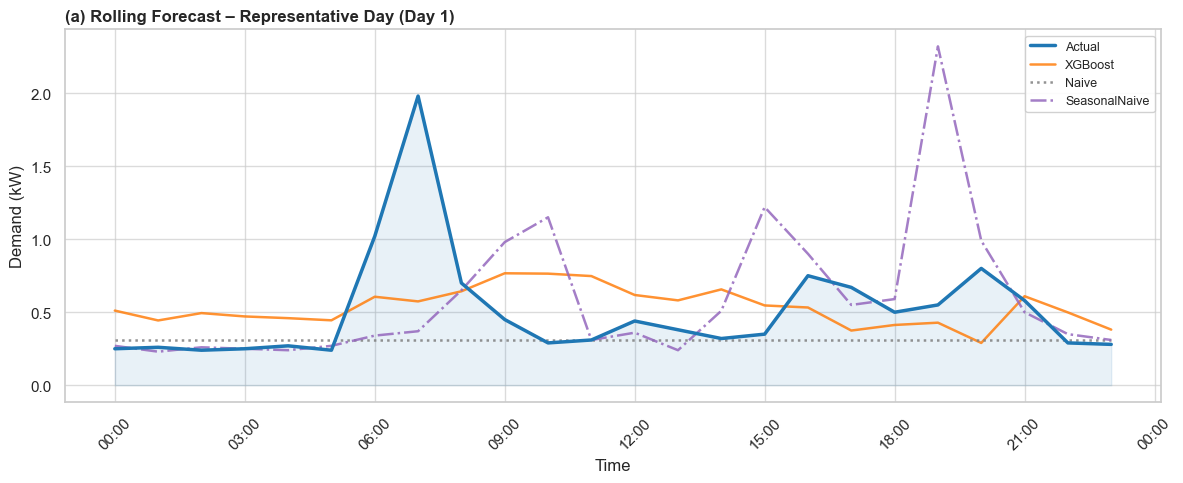

  → Saved: 09_day_overlay_rep.png


In [9]:
# =============================================================================
# Figure 1: Representative Day Overlay - Academic Style
# =============================================================================
if predictions_clean.empty:
    raise ValueError("No predictions available for plotting.")

# Select a representative day (day with most data)
day_lengths = predictions_clean.groupby("day_idx")["timestamp"].nunique()
plot_day = int(day_lengths.idxmax())

plot_df = predictions_clean[predictions_clean["day_idx"] == plot_day].copy()
actual_series = plot_df.groupby("timestamp")["y_true"].first()
pivot_df = plot_df.pivot_table(index="timestamp", columns="model_name", values="y_pred")

fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('white')

# Plot actual demand
ax.plot(actual_series.index, actual_series.values, 
        label="Actual", color=COLORS["Actual"], linewidth=2.5, zorder=5)
ax.fill_between(actual_series.index, 0, actual_series.values, 
                alpha=0.1, color=COLORS["Actual"])

# Plot model predictions
linestyles = {"XGBoost": "-", "SARIMA": "--", "Naive": ":", "SeasonalNaive": "-."}
for model_name in ["XGBoost", "SARIMA", "Naive", "SeasonalNaive"]:
    if model_name in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[model_name], 
                label=model_name, 
                color=COLORS.get(model_name, "#000"), 
                linewidth=1.8, 
                linestyle=linestyles.get(model_name, "-"),
                alpha=0.85)

ax.set_title(f"(a) Rolling Forecast – Representative Day (Day {plot_day})", 
             fontsize=12, fontweight="bold", loc="left")
ax.set_xlabel("Time", fontweight="medium")
ax.set_ylabel("Demand (kW)", fontweight="medium")
ax.legend(loc="upper right", framealpha=0.9, fontsize=9)
ax.tick_params(axis="x", rotation=45)

# Format x-axis for readability
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))

save_figure(fig, "day_overlay_rep")

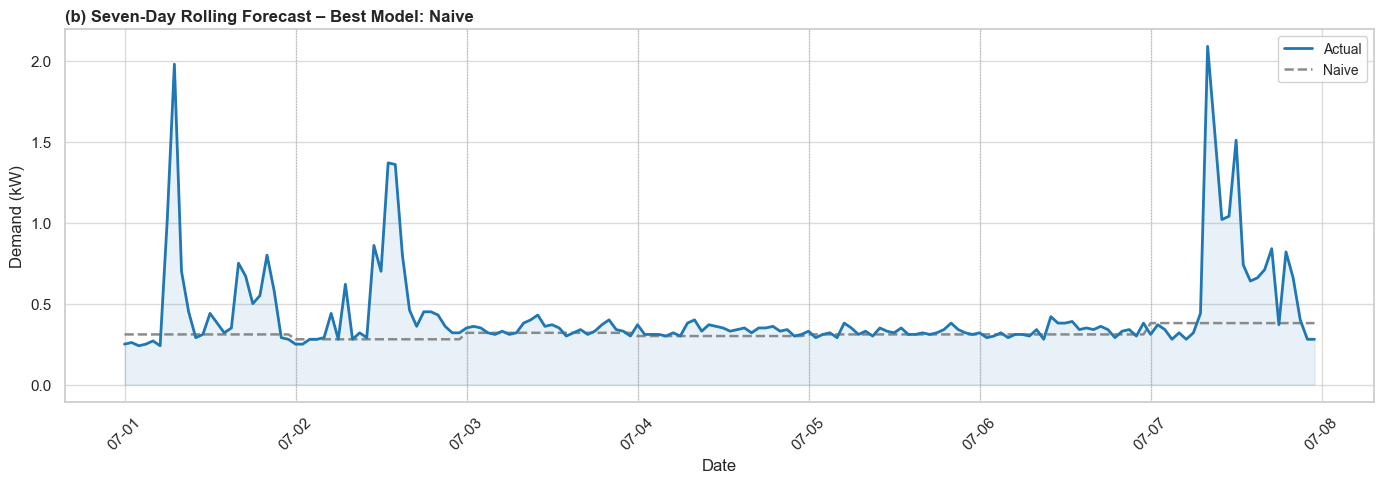

  → Saved: 09_week_overlay_best.png


In [10]:
# =============================================================================
# Figure 2: Seven-Day Overlay (Best Model) - Academic Style
# =============================================================================
if validation_metrics_df.empty:
    best_model = "XGBoost"
else:
    best_model = validation_metrics_df.sort_values("nRMSE").iloc[0]["model_name"]

best_df = predictions_clean[predictions_clean["model_name"] == best_model].copy()
actual_series = predictions_clean.groupby("timestamp")["y_true"].first().sort_index()

fig, ax = plt.subplots(figsize=(14, 5))
fig.patch.set_facecolor('white')

# Plot actual demand
ax.plot(actual_series.index, actual_series.values, 
        label="Actual", color=COLORS["Actual"], linewidth=2, zorder=5)
ax.fill_between(actual_series.index, 0, actual_series.values, 
                alpha=0.1, color=COLORS["Actual"])

# Plot best model predictions
ax.plot(best_df["timestamp"], best_df["y_pred"], 
        label=best_model, 
        color=COLORS.get(best_model, "#ff7f0e"), 
        linewidth=1.8, 
        linestyle="--",
        alpha=0.9)

# Add vertical lines for day boundaries
for i, day in enumerate(pd.to_datetime(best_df["timestamp"].dt.floor("D").unique())):
    if i > 0:
        ax.axvline(day, color="gray", linestyle=":", alpha=0.4, linewidth=0.8)

ax.set_title(f"(b) Seven-Day Rolling Forecast – Best Model: {best_model}", 
             fontsize=12, fontweight="bold", loc="left")
ax.set_xlabel("Date", fontweight="medium")
ax.set_ylabel("Demand (kW)", fontweight="medium")
ax.legend(loc="upper right", framealpha=0.9, fontsize=10)
ax.tick_params(axis="x", rotation=45)

# Format x-axis
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())

save_figure(fig, "week_overlay_best")

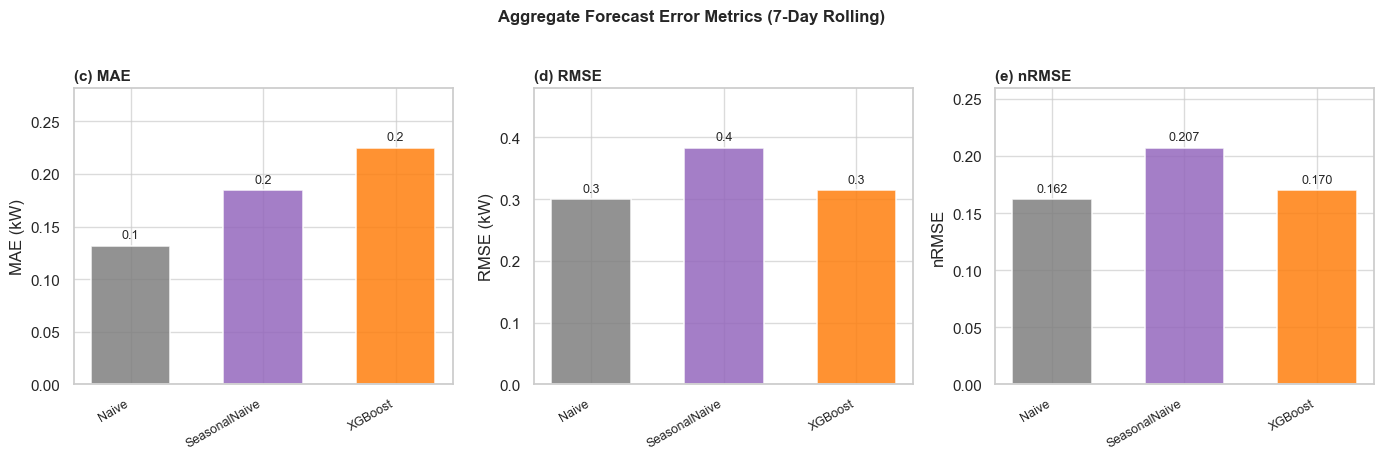

  → Saved: 09_metrics_comparison.png


In [11]:
# =============================================================================
# Figure 3: Model Comparison Bar Chart - Academic Style
# =============================================================================
if validation_metrics_df.empty:
    raise ValueError("Validation metrics is empty")

# Prepare data for grouped bar chart
models = validation_metrics_df["model_name"].values
x = np.arange(len(models))
width = 0.25

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
fig.patch.set_facecolor('white')

metrics = ["MAE", "RMSE", "nRMSE"]
units = ["kW", "kW", ""]
subplot_labels = ["(c)", "(d)", "(e)"]

for idx, (metric, unit, label) in enumerate(zip(metrics, units, subplot_labels)):
    ax = axes[idx]
    values = validation_metrics_df[metric].values
    
    # Create bars with model-specific colors
    bars = ax.bar(x, values, width=0.6, 
                  color=[COLORS.get(m, "#888") for m in models],
                  edgecolor="white", linewidth=1.2, alpha=0.85)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.3f}' if metric == "nRMSE" else f'{val:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='medium')
    
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=30, ha='right', fontsize=9)
    ylabel = f"{metric} ({unit})" if unit else metric
    ax.set_ylabel(ylabel, fontweight="medium")
    ax.set_title(f"{label} {metric}", fontsize=11, fontweight="bold", loc="left")
    ax.set_ylim(0, max(values) * 1.25)

fig.suptitle("Aggregate Forecast Error Metrics (7-Day Rolling)", 
             fontsize=12, fontweight="bold", y=1.02)

save_figure(fig, "metrics_comparison")